In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, \
                        accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification, make_regression
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from arbitragelab.ml_approach.mlp_regressor import MLPRegressor
from arbitragelab.ml_approach.mlp_classifier import MLPClassifier

from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier


In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aaron/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
Using TensorFlow backend.


# Regressor Ensemble

In [3]:
X, y = make_regression(500)

In [4]:
n_frames, frame_size = X.shape
regressor = MLPRegressor(frame_size)
regressor2 = MLPRegressor(frame_size)

r_estimator = KerasRegressor(build_fn=regressor.build, epochs=100, batch_size=10, verbose=False)
r_estimator._estimator_type = 'regressor'

r_estimator2 = KerasRegressor(build_fn=regressor2.build, epochs=100, batch_size=10, verbose=False)
r_estimator2._estimator_type = 'regressor'

r_voter = VotingRegressor([('reg1', r_estimator), ('reg2', r_estimator2)]) 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

r_voter.fit(X_train, y_train)
y_pred = r_voter.predict(X_test)

In [6]:
print(r2_score(y_test, r_voter.predict(X_test)))

0.9208692626291369


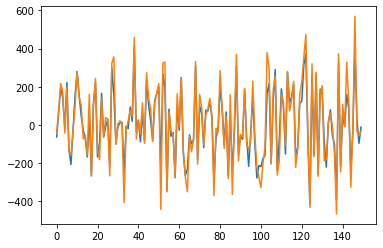

In [8]:
plt.plot(r_voter.predict(X_test))
plt.plot(y_test)

# Classifier Ensemble

In [61]:
X, y = make_classification(500)

In [89]:
class RevisedKerasClassifier(KerasClassifier):

    def predict(self, x, **kwargs):
        """Returns the class predictions for the given test data.
        Arguments:
            x: array-like, shape `(n_samples, n_features)`
                Test samples where `n_samples` is the number of samples
                and `n_features` is the number of features.
            **kwargs: dictionary arguments
                Legal arguments are the arguments
                of `Sequential.predict_classes`.
        Returns:
            preds: array-like, shape `(n_samples,)`
                Class predictions.
        """
        
        result = super().predict(x, **kwargs)
        return np.ravel(result)

In [90]:
n_frames, frame_size = X.shape

classifier = MLPClassifier(frame_size)
classifier2 = MLPClassifier(frame_size)

c_estimator = RevisedKerasClassifier(build_fn=classifier.build, epochs=400, batch_size=10, verbose=False)
c_estimator._estimator_type = 'classifier'

c_estimator2 = RevisedKerasClassifier(build_fn=classifier2.build, epochs=400, batch_size=10, verbose=False)
c_estimator2._estimator_type = 'classifier'

c_voter = VotingClassifier([('cls1', c_estimator), ('cls2', c_estimator2)])

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [92]:
c_voter.fit(X_train, y_train)

VotingClassifier(estimators=[('cls1',
                              <__main__.RevisedKerasClassifier object at 0x7f3335998e48>),
                             ('cls2',
                              <__main__.RevisedKerasClassifier object at 0x7f3335998eb8>)])

In [93]:
y_score_as_category = c_voter.predict(X_test)

forecast_result_df = pd.DataFrame( y_test )
forecast_result_df['pred'] = y_score_as_category
forecast_result_df.columns = ['actual', 'pred']

# Performance Metrics
actual = forecast_result_df['actual']
pred = forecast_result_df['pred']
print(classification_report(y_true=actual, y_pred=pred))
print(accuracy_score(y_true=actual, y_pred=pred))


[0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0
 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0
 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0
 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0
 1 0] [0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0
 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0
 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0
 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0
 1 0]
[0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1
 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0
 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0
 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0
 1 1] [0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1
 1 1 0 